In this project I'm going to present model for accommodation price prediction. 
We start with importing dependencies:

In [2]:
from collections import Counter
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")

Next we can load the datasets for trains and prediction.

In [3]:
df_train = pd.read_csv('train.csv')
df_submission = pd.read_csv('submission.csv')
df = pd.concat([df_train, df_submission], keys=['train', 'submission'])
print(f"Shape of dataset: {df.shape}")
print(df.head())
print(df.info())

Shape of dataset: (3631, 45)
                                        name  \
train 0       Guest Quarters on Capitol Hill   
      1  Private oasis. Top floor w/ 2 decks   
      2    People's Place -Convention Center   
      3                           M St Apt C   
      4   Columbia Heights Rm w/Private Bath   

                                                   summary  \
train 0  The  Guest Quarters on Capitol Hill is a garde...   
      1  Top two floors, two bathrooms and two decks. M...   
      2                                                NaN   
      3  Inspired by MidEast styles. 1 full bed, 1 air ...   
      4  Enjoy our dressed up guest room in the heart o...   

                                               description  \
train 0  The  Guest Quarters on Capitol Hill is a garde...   
      1  Top two floors, two bathrooms and two decks. M...   
      2  This 2 bedroom apartment is on the ground floo...   
      3  Inspired by MidEast styles. 1 full bed, 1 air ...   

## Data processing and feature engineering.
At first we will convert numeric columns to numbers.

In [4]:
# Converting price columns to numbers
print(f"Price column before conversion:\n{df['price'].head(2)}")
for column in ['price', 'cleaning_fee']:
    df[column] = df[column].apply(lambda x: float(str(x).replace(',', '').split('$')[-1]))
print(f"Price column after conversion:\n{df['price'].head(2)}")

# Converting percent columns to numbers
print(f"Percent columns before conversion:\n{df['host_response_rate'].unique(), df['host_acceptance_rate'].unique()}")
for column in ['host_response_rate', 'host_acceptance_rate']:
    df[column] = df[column].fillna(0).apply(lambda x: 0.01 * int(str(x).split('%')[0]))
print(f"Percent columns after conversion:\n{df['host_response_rate'].unique(), df['host_acceptance_rate'].unique()}")

# Converting boolean to numbers
print(f"Instant_bookable column before conversion:\n{df['instant_bookable'].head(2)}")
df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 0 if x == 'f' else (1 if x == 't' else None))
print(f"Instant_bookable column after conversion:\n{df['instant_bookable'].head(2)}")

Price column before conversion:
train  0    $195.00
       1    $150.00
Name: price, dtype: object
Price column after conversion:
train  0    195.0
       1    150.0
Name: price, dtype: float64
Percent columns before conversion:
(array(['98%', '100%', '97%', '92%', nan, '90%', '58%', '89%', '30%',
       '93%', '91%', '82%', '75%', '50%', '68%', '67%', '80%', '63%',
       '70%', '60%', '94%', '96%', '33%', '78%', '83%', '81%', '99%',
       '20%', '64%', '85%', '40%', '62%', '86%', '95%', '56%', '84%',
       '43%', '54%', '73%', '71%', '87%', '88%', '59%', '57%', '79%',
       '36%', '7%', '32%', '53%', '69%', '77%', '25%', '74%', '52%',
       '41%', '66%', '76%', '17%', '27%', '65%', '47%'], dtype=object), array(['52%', '100%', '75%', '90%', nan, '88%', '94%', '50%', '99%',
       '92%', '51%', '76%', '98%', '69%', '73%', '71%', '57%', '0%',
       '56%', '91%', '77%', '62%', '67%', '55%', '97%', '63%', '60%',
       '85%', '96%', '93%', '40%', '89%', '86%', '81%', '80%', '79%',
  

Now we will be exploring object columns. We will drop textual columns like name, summary, description. We keep smart_location as location identifier because it contains city, state, and market values. We will also drop 'country_code' and 'country' because our dataset contains only one country.

In [5]:
print(f"Object columns:\n{df.select_dtypes(object).head(2)}")
textual_columns_to_drop = ['name', 'summary', 'description', 'neighborhood_overview', 'transit', 'host_location',
                           'host_about', 'city', 'state', 'market', 'country_code', 'country']
df.drop(textual_columns_to_drop, axis=1, inplace=True)

Object columns:
                                        name  \
train 0       Guest Quarters on Capitol Hill   
      1  Private oasis. Top floor w/ 2 decks   

                                                   summary  \
train 0  The  Guest Quarters on Capitol Hill is a garde...   
      1  Top two floors, two bathrooms and two decks. M...   

                                               description  \
train 0  The  Guest Quarters on Capitol Hill is a garde...   
      1  Top two floors, two bathrooms and two decks. M...   

                                     neighborhood_overview  \
train 0  the convenience and charm of being on Capitol ...   
      1  Adams Morgan is the most vibrant part of DC wh...   

                                                   transit  host_since  \
train 0  The Red Line and the Blue Line Metros are with...  2013-08-14   
      1  There is so many transportation options. Acros...  2012-01-23   

                                           host_locatio

Now let's check if neighbourhood and location columns do not contain values with slightly different spelling, and will treat these values as one entity if there are any.

In [6]:
# Check if host_neighbourhood do not contain values with slightly different spelling
host_neighbourhood_unique = df['host_neighbourhood'].dropna().unique()
host_neighbourhood_unique.sort()
print(f"Host_neighbourhood column unique values:\n{host_neighbourhood_unique}")

# As we can see Mount Pleasant and Mt. Pleasant is the same entity, so we replace Mt. Pleasant
df['host_neighbourhood'] = df['host_neighbourhood'].apply(lambda x: 'Mount Pleasant' if x == 'Mt. Pleasant' else x)
host_neighbourhood_unique = df['host_neighbourhood'].dropna().unique()
host_neighbourhood_unique.sort()
print(f"Host_neighbourhood column after processing:\n{host_neighbourhood_unique}")

# Check if neighbourhood_cleansed do not contain values with slightly different spelling
neighbourhood_cleansed_unique = df['neighbourhood_cleansed'].unique()
neighbourhood_cleansed_unique.sort()
print(f"Neighbourhood_cleansed column unique values:\n{neighbourhood_cleansed_unique}")

# Check if smart_location do not contain values with slightly different spelling
smart_location_unique = df['smart_location'].unique()
smart_location_unique.sort()
print(f"Smart_location column unique values:\n{smart_location_unique}")

# As we can see, there are three different spelling of 'Washington, DC', replace them with one
df['smart_location'] = df['smart_location'].apply(lambda x: 'Washington, DC' if x in ('Washington, D.C., DC',
                                                                                      'Washington , DC') else x)
smart_location_unique = df['smart_location'].unique()
smart_location_unique.sort()
print(f"Smart_location column after processing:\n{smart_location_unique}")

Host_neighbourhood column unique values:
['16th Street Heights' 'Adams Morgan' 'American University Park'
 'Anacostia' 'Astoria' 'Aurora Highlands' 'Ballston/Virginia Square'
 'Barney Circle' 'Bedford-Stuyvesant' 'Bellevue' 'Benning'
 'Benning Heights' 'Berkley' 'Bloomingdale' 'Brentwood' 'Brickell'
 'Brightwood' 'Brookland' 'Buena Vista' 'Burleith' 'Cambridge'
 'Capitol Heights, MD' 'Capitol Hill' 'Carver Langston'
 'Cathedral Heights' 'Catholic University'
 'Central Northeast/Mahaning Heights' 'Chevy Chase' 'Chillum, MD'
 'Cleveland Park' 'Clinton Hill' 'Colonial Village' 'Columbia Heights'
 'Congress Heights' 'Crestwood' 'Deanwood' 'Douglas Park' 'Douglass'
 'Downtown/Penn Quarter' 'Dupont Circle' 'Dupont Park' 'East Corner'
 'Eastland Gardens' 'Eckington' 'Edgewood' 'Fairlawn' 'Fenway/Kenmore'
 'Foggy Bottom' 'Forest Hills' 'Fort Davis' 'Fort Dupont' 'Fort Lincoln'
 'Foxhall' 'Friendship Heights' 'Gallaudet' 'Garfield Heights'
 'Gay Village' 'Georgetown' 'Glover Park' 'Gold Coast' 

Let's count locations. As we can see, there are a number of locations with small row counts. We will drop them.

In [7]:
print(f"Counting locations: \n{df['smart_location'].value_counts()}")
df.drop(df[df['smart_location'] != 'Washington, DC'].index, inplace=True)
print(f"Smart_location after dropping loctions with small row counts: \n{df['smart_location'].value_counts()}")
# When only one location left, we can drop entire column
df.drop('smart_location', axis=1, inplace=True)

Counting locations: 
Washington, DC                         3601
Silver Spring, MD                         8
Takoma Park, MD                           6
Mount Rainier, MD                         5
Hyattsville, MD                           2
New York, NY                              1
Columbia Heights, middle of DC!, DC       1
Arlington, VA                             1
Dupont Circle, DC                         1
Capitol Heights, MD                       1
chevy chase, MD                           1
Adams Morgan, Washington DC               1
Capitol Hill, Washington, DC              1
Annapolis, MD                             1
Name: smart_location, dtype: int64
Smart_location after dropping loctions with small row counts: 
Washington, DC    3601
Name: smart_location, dtype: int64


Checking the rest columns

In [8]:
# Check if property_type do not contain values with slightly different spelling
print(f"Property_type column unique values:\n{df['property_type'].unique()}")
# Check if room_type do not contain values with slightly different spelling
print(f"Room_type column unique values:\n{df['room_type'].unique()}")
# Check if bed_type do not contain values with slightly different spelling
print(f"Bed_type column unique values:\n{df['bed_type'].unique()}")

Property_type column unique values:
['Apartment' 'House' 'Townhouse' 'Bed & Breakfast' 'Condominium' 'Cabin'
 'Other' 'Loft' 'Boat' 'Dorm' nan 'Bungalow']
Room_type column unique values:
['Entire home/apt' 'Private room' 'Shared room']
Bed_type column unique values:
['Real Bed' 'Pull-out Sofa' 'Futon' 'Couch' 'Airbed']


Now we will process amenities column

In [9]:
amenities = [amenity.strip('\"') for record in df['amenities'] for amenity in record[1:-1].split(',')]
print(f"Counting amenities:\n{Counter(amenities)}")

Counting amenities:
Counter({'Air Conditioning': 3450, 'Heating': 3427, 'Wireless Internet': 3411, 'Kitchen': 3323, 'Washer': 2932, 'Dryer': 2904, 'Smoke Detector': 2879, 'Internet': 2848, 'Essentials': 2769, 'TV': 2716, 'Shampoo': 1917, 'Cable TV': 1852, 'Fire Extinguisher': 1804, 'Family/Kid Friendly': 1727, 'Carbon Monoxide Detector': 1612, 'First Aid Kit': 1143, 'Free Parking on Premises': 1068, 'Elevator in Building': 1007, 'Pets live on this property': 593, 'Gym': 590, 'Buzzer/Wireless Intercom': 493, 'Indoor Fireplace': 491, 'Safety Card': 486, 'Pets Allowed': 453, 'Doorman': 419, 'Dog(s)': 412, 'Wheelchair Accessible': 339, 'Pool': 320, 'Breakfast': 267, 'Cat(s)': 224, 'Suitable for Events': 206, 'Hot Tub': 169, 'Smoking Allowed': 85, '': 55, 'Other pet(s)': 16, 'Washer / Dryer': 4})


We have 3601 rows in our dataset, as we can see, such amenities as 'Air Conditioning': 3450, 'Heating': 3427,
'Wireless Internet': 3411, 'Kitchen': 3323 are presented in almost every apartment, so we are interested in more
distinctive features like 'Shampoo', 'Family/Kid Friendly', 'Carbon Monoxide Detector', 'Free Parking on Premises',
'Elevator in Building', 'Gym', 'Pets Allowed', 'Wheelchair Accessible', 'Breakfast', 'Pool', 'Smoking Allowed'.
So now we are going to create new features for amenities and one feature for amenities_count.

In [10]:
amenities = ['Shampoo', 'Family/Kid Friendly', 'Carbon Monoxide Detector', 'Free Parking on Premises', 'Breakfast',
             'Elevator in Building', 'Gym', 'Pets Allowed', 'Wheelchair Accessible', 'Pool', 'Smoking Allowed']
for amenity in amenities:
    df[amenity.lower()] = df['amenities'].apply(lambda x: int(amenity in x))
df['amenities_count'] = df.amenities.apply(lambda x: len(str(x)[1:].split(',')))
df.drop('amenities', axis=1, inplace=True)
print(f"New columns from amenities list:\n{df.loc[:, 'shampoo':'amenities_count'].head()}")

New columns from amenities list:
         shampoo  family/kid friendly  carbon monoxide detector  \
train 0        0                    0                         0   
      1        1                    1                         1   
      2        0                    1                         0   
      3        1                    1                         0   
      4        0                    0                         0   

         free parking on premises  breakfast  elevator in building  gym  \
train 0                         0          0                     0    0   
      1                         0          0                     0    0   
      2                         0          0                     0    0   
      3                         0          0                     0    0   
      4                         0          0                     0    0   

         pets allowed  wheelchair accessible  pool  smoking allowed  \
train 0             0                     

Now let's look at host_since column. We can treat these values as host experience, so we can calculate difference
between today date and host_since date and save it as number.

In [11]:
print(f"Null data: {df['host_since'].isna().sum()}")
df['host_experience'] = df['host_since'].apply(lambda x: int(str(date.today() - date.fromisoformat(x)).split(' ')[0]))
df.drop('host_since', axis=1, inplace=True)
print(f"Host experience column:\n{df['host_experience'].head(2)}")

Null data: 0
Host experience column:
train  0    2535
       1    3104
Name: host_experience, dtype: int64


We will count the number of host verifications methods and save it as host_verifications_count column.

In [12]:
df['host_verifications_count'] = df['host_verifications'].apply(lambda x: len(x.split(', ')))
df.drop('host_verifications', axis=1, inplace=True)
print(f"Host verifications count column:\n{df['host_verifications_count'].head(2)}")

Host verifications count column:
train  0    4
       1    5
Name: host_verifications_count, dtype: int64


## Dealing with missing values

In [13]:
print(f"Missing values count for the whole dataset:\n{df.isnull().sum().sort_values(ascending=False).head(20)}")

Missing values count for the whole dataset:
cleaning_fee                   1344
review_scores_checkin           849
review_scores_cleanliness       849
review_scores_accuracy          848
review_scores_communication     845
review_scores_location          845
review_scores_value             845
review_scores_rating            841
reviews_per_month               804
price                           612
host_neighbourhood              250
bathrooms                        25
bedrooms                         15
beds                             10
zipcode                           9
property_type                     1
accommodates                      0
neighbourhood_cleansed            0
host_acceptance_rate              0
maximum_nights                    0
dtype: int64


Columns bathrooms, bedrooms, beds, zipcode, property_type contain small number of nan values, so we can just drop these rows

In [15]:
df.dropna(axis=0, how='any', subset=['bathrooms', 'bedrooms', 'beds', 'zipcode', 'property_type'], inplace=True)
print(df.isnull().sum().sort_values(ascending=False).head(20))

cleaning_fee                   1322
review_scores_checkin           831
review_scores_cleanliness       831
review_scores_accuracy          830
review_scores_communication     827
review_scores_location          827
review_scores_value             827
review_scores_rating            824
reviews_per_month               788
price                           607
host_neighbourhood              244
accommodates                      0
property_type                     0
host_acceptance_rate              0
maximum_nights                    0
neighbourhood_cleansed            0
zipcode                           0
guests_included                   0
minimum_nights                    0
bathrooms                         0
dtype: int64


As we can see, there are 800+ rows that does not contain review scores, we will make one-hot encoding for review_scores_rating with special column for 'no reviews', while dropping other review scores columns. We will also fill nan with 0 for reviews_per_month column.

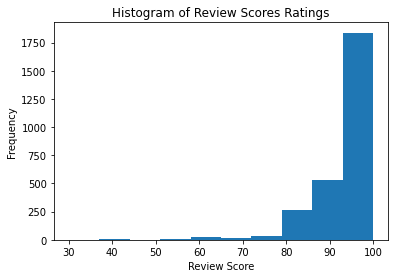

In [16]:
plt.hist(df['review_scores_rating'][~df['review_scores_rating'].isnull()])
plt.title("Histogram of Review Scores Ratings")
plt.xlabel("Review Score")
plt.ylabel("Frequency")
plt.show()

In [17]:
print("Counting different scores in review_scores_rating column:\n",
      df['review_scores_rating'].value_counts().sort_index(ascending=False).head(15))
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['review_scores_rating'] = df['review_scores_rating'].fillna('no rating')


def group_review_scores(score):
    if score == 'no rating':
        return 'no rating'
    elif score > 98:
        return '99-100'
    elif score > 96:
        return '97-98'
    elif score > 94:
        return '95-96'
    elif score > 92:
        return '93-94'
    elif score > 90:
        return '91-92'
    elif score > 88:
        return '89-90'
    elif score > 86:
        return '87-88'
    elif score > 84:
        return '85-86'
    elif score > 82:
        return '83-84'
    elif score > 75:
        return '76-82'
    elif score > 69:
        return '70-75'
    elif score > 59:
        return '60-69'
    elif score > 44:
        return '45-59'
    elif score > 0:
        return '0-44'


df['review_scores_rating'] = df['review_scores_rating'].apply(group_review_scores)
one_hot_review = pd.get_dummies(df['review_scores_rating'], prefix='review rating:', prefix_sep=" ")
df = df.join(one_hot_review)
review_columns_to_drop = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                          'review_scores_value']
df.drop(review_columns_to_drop, axis=1, inplace=True)
print(f"One-hot encoded review rating columns:\n{df.loc[:, 'review rating: 0-44':].head(5)}")


Counting different scores in review_scores_rating column:
 100.0    747
99.0      87
98.0     162
97.0     180
96.0     178
95.0     191
94.0     111
93.0     182
92.0      97
91.0      75
90.0     160
89.0      49
88.0      60
87.0      61
86.0      32
Name: review_scores_rating, dtype: int64
One-hot encoded review rating columns:
         review rating: 0-44  review rating: 45-59  review rating: 60-69  \
train 0                    0                     0                     0   
      1                    0                     0                     0   
      2                    0                     0                     0   
      3                    0                     0                     0   
      4                    0                     0                     0   

         review rating: 70-75  review rating: 76-82  review rating: 83-84  \
train 0                     0                     0                     0   
      1                     0                     0    

Let's look at price and cleaning fee columns. We will drop outliers and explore correlation between them

Price frequency:
2822.0    1
2000.0    3
1500.0    1
1400.0    1
1300.0    1
Name: price, dtype: int64
Price frequency after dropping top values:
1500.0    1
1400.0    1
1300.0    1
1250.0    2
1200.0    4
Name: price, dtype: int64
Cleaning fee frequency:
400.0    1
300.0    7
258.0    1
250.0    4
240.0    1
Name: cleaning_fee, dtype: int64


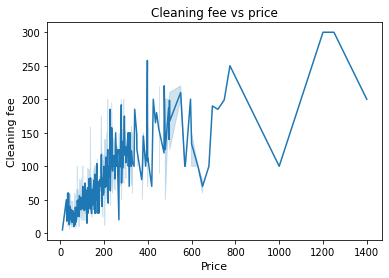

In [18]:
print(f"Price frequency:\n{df['price'].value_counts().sort_index(ascending=False).head()}")
df.drop(df[df['price'] > 1500].index, inplace=True)
print(f"Price frequency after dropping top values:\n{df['price'].value_counts().sort_index(ascending=False).head()}")
print(f"Cleaning fee frequency:\n{df['cleaning_fee'].value_counts().sort_index(ascending=False).head()}")
plt.title("Cleaning fee vs price")
sns.lineplot(x='price', y='cleaning_fee', data=df[['price', 'cleaning_fee']])
plt.xlabel('Price', fontsize=11)
plt.ylabel('Cleaning fee', fontsize=11)
plt.show()

As we can see, the correlation between cleaning fee and the price in non-linear, with many outliers. So we will interpolate cleaning fee curve in order to fill its missing values.

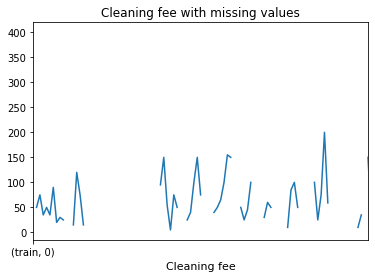

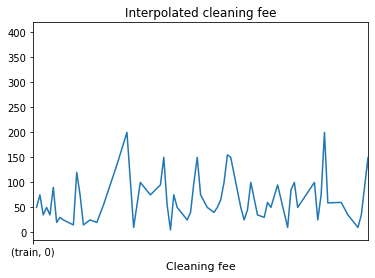

Left missing values :
price                       607
host_neighbourhood          244
review rating: no rating      0
shampoo                       0
reviews_per_month             0
dtype: int64


In [19]:
plt.title("Cleaning fee with missing values")
df['cleaning_fee'].plot().set_xlim(0, 100)
plt.xlabel('Cleaning fee', fontsize=11)
plt.show()

plt.title("Interpolated cleaning fee")
df['cleaning_fee'].interpolate().plot().set_xlim(0, 100)
plt.xlabel('Cleaning fee', fontsize=11)
plt.show()

df['cleaning_fee'] = df['cleaning_fee'].interpolate()
df.dropna(axis=0, how='any', subset=['cleaning_fee'], inplace=True)
print(f"Left missing values :\n{df.isnull().sum().sort_values(ascending=False).head()}")

Finally we will drop nan host_neighbourhood values

In [20]:
df.dropna(axis=0, how='any', subset=['host_neighbourhood'], inplace=True)
print(f"Left missing values :\n{df.isnull().sum().sort_values(ascending=False).head()}")

Left missing values :
price                             564
review rating: no rating            0
shampoo                             0
reviews_per_month                   0
calculated_host_listings_count      0
dtype: int64


Before proceeding, we have to convert categorical columns

In [21]:
for column in ['host_neighbourhood', 'neighbourhood_cleansed', 'zipcode', 'property_type',
               'room_type', 'bed_type', 'cancellation_policy']:
    df[column] = df[column].astype('category')
    df[column] = df[column].cat.codes
print(f"Final shape of dataset: {df.shape}")
print(df.head())
print(df.info())

Final shape of dataset: (3298, 51)
         host_response_rate  host_acceptance_rate  host_neighbourhood  \
train 1                1.00                  1.00                   1   
      2                0.97                  1.00                   8   
      3                0.92                  1.00                 102   
      4                1.00                  0.75                  92   
      5                1.00                  1.00                 109   

         neighbourhood_cleansed  zipcode  property_type  room_type  \
train 1                      22       12              0          0   
      2                      29        0              0          0   
      3                      29        0              0          0   
      4                       7        0              6          1   
      5                      37       21              6          1   

         accommodates  bathrooms  bedrooms  ...  review rating: 83-84  \
train 1             2        1.5

## Building regressor

Split dataset to train and test

In [22]:
y = df['price'].loc['train']
X = df.drop(['price'], axis=1).loc['train']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train dataset shape: {X_train.shape, y_train.shape}")
print(f"Test dataset shape: {X_test.shape, y_test.shape}")

Train dataset shape: ((2187, 50), (2187,))
Test dataset shape: ((547, 50), (547,))


We are going to try different models and compare their R2 scores

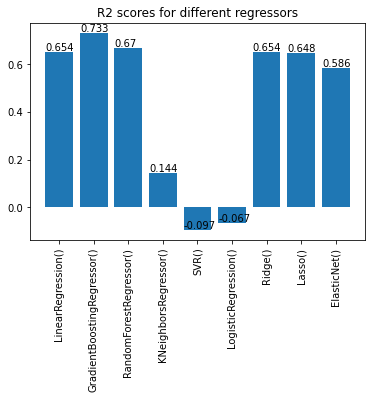

In [23]:
models = [LinearRegression(),
          GradientBoostingRegressor(),
          RandomForestRegressor(),
          KNeighborsRegressor(),
          SVR(),
          LogisticRegression(),
          Ridge(),
          Lasso(),
          ElasticNet()]

r2_scores = {}
for model in models:
    model.fit(X_train, y_train)
    r2_scores[str(model)] = (r2_score(y_test, model.predict(X_test)))

# Plot r2 scores
bars = plt.bar(range(len(r2_scores)), list(r2_scores.values()), align='center')
plt.xticks(range(len(r2_scores)), list(r2_scores.keys()), rotation=90)
for bar in bars:
    yval = round(bar.get_height(), 3)
    plt.text(bar.get_x(), yval + .005, yval)
plt.title('R2 scores for different regressors')
plt.show()

As we can see, Gradient Boosting model has the best score. Negative R2 scores mean that these models fit the data worse than a horizontal line.

Now we wil try to optimize Gradient Boosting regressor by running GridSearchCV

In [24]:
params_gradient_boosting = {'learning_rate': [0.1, 0.07, 0.05],
                            'max_depth': [4, 5, 6],
                            'min_samples_leaf': [3, 5, 9],
                            'max_features': [0.2, 0.1, 0.01],
                            'n_estimators': [100, 250, 500]}
gradient_boosting = GradientBoostingRegressor(random_state=42)
gs = GridSearchCV(gradient_boosting, params_gradient_boosting, cv=3, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print(f"The best estimator across ALL searched params:\n{gs.best_estimator_}")
print(f"The best score across ALL searched params:\n{gs.best_score_}")
print(f"The best parameters across ALL searched params:\n{gs.best_params_}")
gradient_boosting_with_gs_params = GradientBoostingRegressor(**gs.best_params_)
gradient_boosting_with_gs_params.fit(X_train, y_train)
print(f"R2 score for GradientBoostingRegressor optimized by GridSearchCV:\n",
      r2_score(y_test, gradient_boosting_with_gs_params.predict(X_test)))

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:  2.7min finished


The best estimator across ALL searched params:
GradientBoostingRegressor(learning_rate=0.07, max_depth=4, max_features=0.1,
                          min_samples_leaf=3, n_estimators=250,
                          random_state=42)
The best score across ALL searched params:
0.5276525408986833
The best parameters across ALL searched params:
{'learning_rate': 0.07, 'max_depth': 4, 'max_features': 0.1, 'min_samples_leaf': 3, 'n_estimators': 250}
R2 score for GradientBoostingRegressor optimized by GridSearchCV:
 0.7182120201018316


GridSearch did not show better result, so will stick with default parameters

In [25]:
gradient_boosting.fit(X_train, y_train)
predicted = gradient_boosting.predict(X_test)
print(f"R2 score for Gradient Boosting with default parameters:\n{r2_score(y_test, predicted)}")

R2 score for Gradient Boosting with default parameters:
0.7380206087366961


Plotting predicted vs actual price

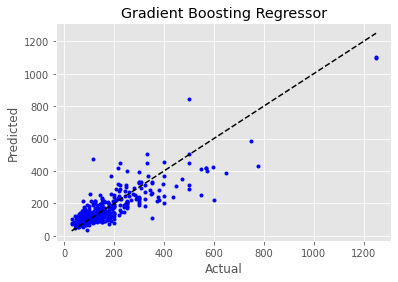

In [26]:
plt.style.use('ggplot')
plt.plot(y_test, predicted, 'b.')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting Regressor')
plt.show()

Let's look at MAE and R2 score on train and test sets. There are quite many outliers in the dataset, so we are using the MAE since the outlier residuals won’t contribute as much to the total error as MSE.

In [27]:
y_train_pred = gradient_boosting.predict(X_train)
y_test_pred = gradient_boosting.predict(X_test)

print(f'MAE train: {mean_absolute_error(y_train, y_train_pred):.3f}, '
      f'test: {mean_absolute_error(y_test, y_test_pred):.3f}')
print(f'R2 score train: {r2_score(y_train, y_train_pred):.3f}, test: {r2_score(y_test, y_test_pred):.3f}')

MAE train: 32.833, test: 40.237
R2 score train: 0.794, test: 0.738


Plotting residuals

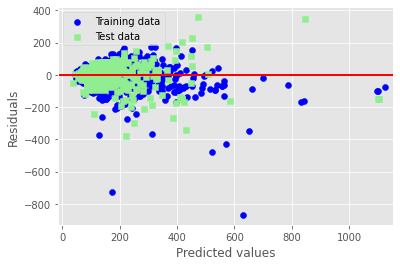

In [28]:
plt.scatter(y_train_pred, y_train_pred-y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred-y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=y_test_pred.min() - 50, xmax=y_test_pred.max() + 50, lw=2, color='red')
plt.xlim([y_test_pred.min() - 50, y_test_pred.max() + 50])
plt.show()

Plotting feature importance

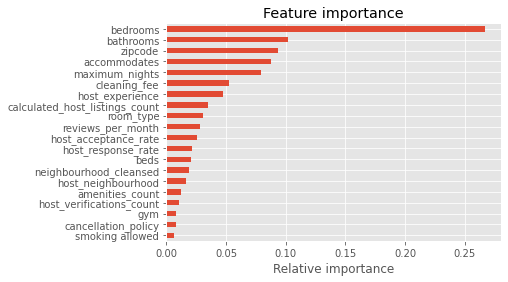

In [29]:
pd.Series(gradient_boosting.feature_importances_, index=X.columns).nlargest(20).plot(kind='barh').invert_yaxis()
plt.xlabel('Relative importance')
plt.title('Feature importance')
plt.show()

The distribution of predicted prices

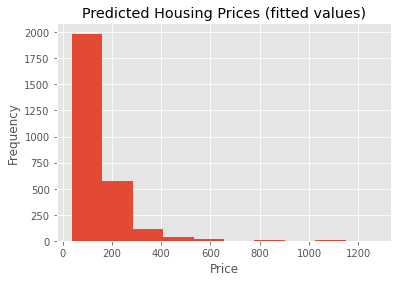

In [31]:
plt.hist(gradient_boosting.predict(X))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Predicted Housing Prices (fitted values)')
plt.show()

Finally we will predict price for submission dataset and save the result.

In [33]:
X_df_submission = df.drop(['price'], axis=1).loc['submission']
df_submission['price_prediction'] = pd.Series(gradient_boosting.predict(X_df_submission), index=X_df_submission.index)
print(df_submission.head())
df_submission.to_csv('submission_with_predicted_price.csv')

                                 name  \
0     Top Location 1 block to Capitol   
1  Charming Basement Apartment in DC    
2        Cozy Apartment to Explore DC   
3      Walk Everywhere! 3 Beds - 2 BR   
4    Luxurious Apartment, Heart of DC   

                                             summary  \
0  Location is unbeatable.   One block to US Capi...   
1  This fully furnished basement apartment can be...   
2  Convenient, newly renovated 1 bedroom/1 bathro...   
3  Location! You're right on 14th street in Logan...   
4  Satisfaction Guaranteed!  If you are not satis...   

                                         description  \
0  Location is unbeatable.   One block to US Capi...   
1  This fully furnished basement apartment can be...   
2  Convenient, newly renovated 1 bedroom/1 bathro...   
3  Location! You're right on 14th street in Logan...   
4  Satisfaction Guaranteed!  If you are not satis...   

                               neighborhood_overview  \
0  Outstanding security

## Future improvements:
- Location features are quite important, so we can treat them for example as one feature - distance to the city center. Or make new feature with coordinates of the house
- We can try different outlier detection methods like empirical covariance, robust covariance, One Class SVM
- Can make use of 'description' or 'neighbourhood_overview' textual data by using NLP techniques
- Better tune GridSearchCV